In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
df = pd.read_csv('/content/wine-reviews.csv', usecols = [ 'country', 'description', 'points', 'price', 'variety', 'winery'] )

In [4]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [5]:
df = df.dropna(subset=['description', 'points'])

In [6]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


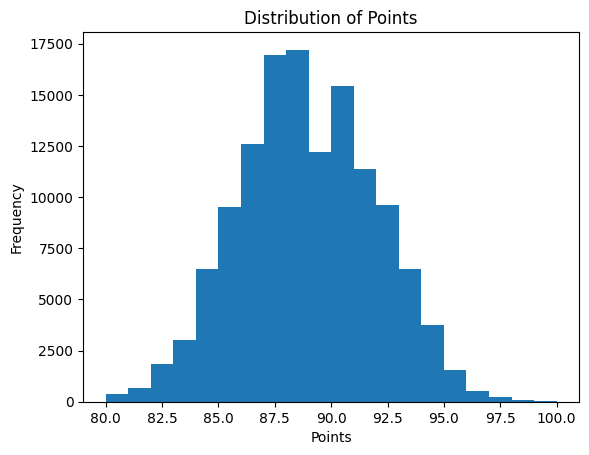

In [7]:
plt.hist(df.points, bins=20)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

In [8]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description', 'points', 'label']]

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  dataframe = dataframe.copy()
  labels = dataframe.pop('label')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.prefetch(tf.data.AUTOTUNE)                                            # Moved prefetch before batch
  ds = ds.batch(batch_size)                                                     # Now batching the prefetched dataset
  return ds                                                                     # Return the batched dataset

In [11]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [12]:
list(train_data)[0]

({'description': <tf.Tensor: shape=(1024,), dtype=string, numpy=
  array([b'This is the inaugural release from this Oregon-based winery, with the fruit coming from Loess and Seven Hills vineyards. A blend of Cabernet Sauvignon (54%), Merlot (38%) and Petit Verdot, it offers laromas of pencil box, high-toned flowers, bittersweet chocolate, herbs and barrel spices. The flavors show depth and intensity as well as exquisite balance and length.',
         b'A vibrant pink hue in the glass, this ros\xc3\xa9 has nice ripe fruit aromas of wild strawberry and fresh cherry that follow through to the juicy, red fruit-dominating mouth. Round and full, the rich mouth could use a bit more cut.',
         b'Fine ripe fruit pushes through the young tannic structure in this fresh wine. It still has an edge of tannin which balances well with the red berry fruits. Acidity cuts through everything to leave a crisp, blueberry flavored aftertaste.',
         ...,
         b'Full bodied and supple, this is a 

**Embedding + Model**

In [13]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [14]:
hub_layer(list(train_data)[0][0]['description'])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.38980678, -0.28954726, -0.11419535, ..., -0.03558318,
        -0.07529705, -0.07223847],
       [ 0.46927756, -0.40860164, -0.2656698 , ..., -0.10116296,
        -0.00341904, -0.16049151],
       [ 0.50137484, -0.3911925 , -0.05568231, ..., -0.03158554,
         0.03480838, -0.07375123],
       ...,
       [ 0.5588327 , -0.2624914 , -0.00696124, ...,  0.09926345,
         0.22797593,  0.08809248],
       [ 0.56008637, -0.32365787,  0.12496108, ...,  0.07541246,
        -0.27455273, -0.15191102],
       [ 0.45331198, -0.17839721,  0.07633097, ..., -0.04175743,
         0.11678786,  0.0413563 ]], dtype=float32)>

In [15]:
import tensorflow as tf
import tensorflow_hub as hub

# ... (rest of your code)

# Define a custom layer that wraps the hub_layer
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(), dtype=tf.string))
model.add(HubLayerWrapper(hub_layer))                                           # Use the wrapper layer
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [17]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.4711 - loss: 0.6985


[0.6986039280891418, 0.47068554162979126]

In [18]:
model.evaluate(val_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4735 - loss: 0.6983


[0.6978774070739746, 0.47857198119163513]

In [19]:
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5731 - loss: 0.6786 - val_accuracy: 0.6184 - val_loss: 0.6451
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6316 - loss: 0.6458 - val_accuracy: 0.6625 - val_loss: 0.6148
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6552 - loss: 0.6244 - val_accuracy: 0.6839 - val_loss: 0.5983
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.6688 - loss: 0.6105 - val_accuracy: 0.6930 - val_loss: 0.5876
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6714 - loss: 0.6057 - val_accuracy: 0.6952 - val_loss: 0.5820
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.6778 - loss: 0.6003 - val_accuracy: 0.7002 - val_loss: 0.5779
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6814 - loss: 0.5976 - val_accuracy: 0.7009 - val_loss: 0.5747
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.6819 - loss: 0.5947 - val_accu

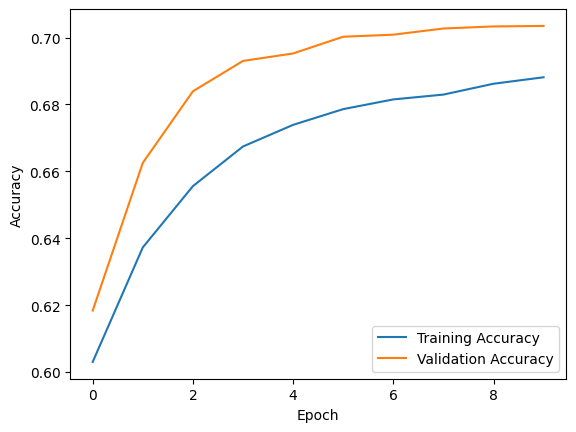

In [20]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

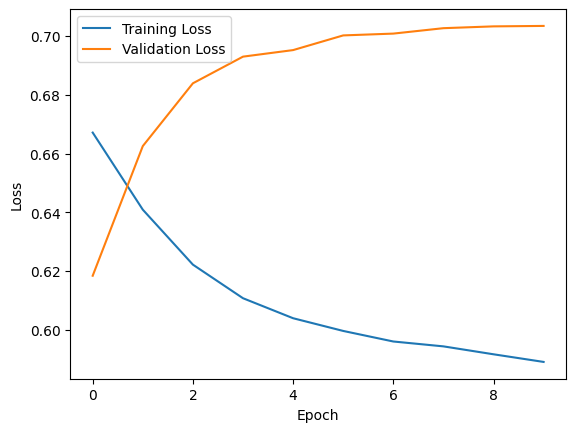

In [21]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7060 - loss: 0.5734


[0.5704889893531799, 0.7089552283287048]

#LSTM

In [23]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
# Extract the 'description' field from the dictionary
encoder.adapt(train_data.map(lambda text, label: text['description']))

In [24]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [25]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),

    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

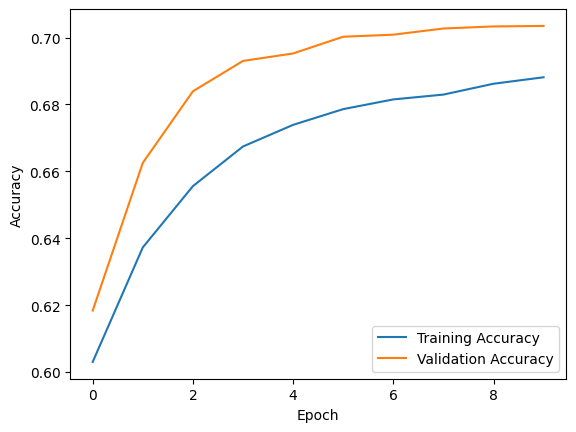

In [27]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

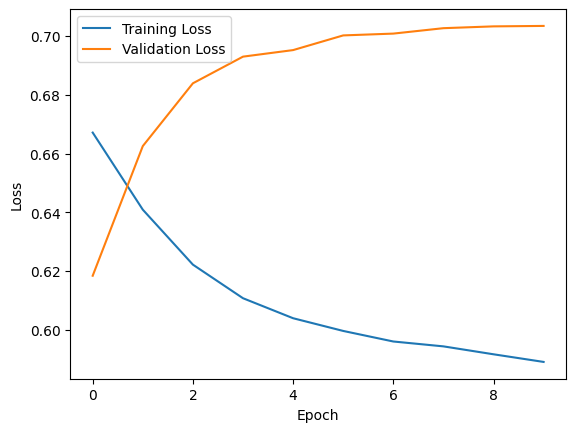

In [29]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_accuracy'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()